In [16]:
import argparse
import sys
import os
import json
import torch
import os
import random
import utils
import data_utils
import json

import cbm
import plots
def parse_args():
    parser = argparse.ArgumentParser(description='Settings for creating CBM')
    # parser.add_argument('--batch_size', default=64, type=int)
    # parser.add_argument('--epochs', default=30, type=int)
    parser.add_argument('--update_freq', default=1, type=int)
    parser.add_argument('--save_ckpt_freq', default=100, type=int)

    # Model parameters
    parser.add_argument('--model', default='vit_base_patch16_224', type=str, metavar='MODEL',
                        help='Name of model to train')
    parser.add_argument('--tubelet_size', type=int, default= 2)
    parser.add_argument('--input_size', default=224, type=int,
                        help='videos input size')

    parser.add_argument('--fc_drop_rate', type=float, default=0.0, metavar='PCT',
                        help='Dropout rate (default: 0.)')
    parser.add_argument('--drop', type=float, default=0.0, metavar='PCT',
                        help='Dropout rate (default: 0.)')
    parser.add_argument('--attn_drop_rate', type=float, default=0.0, metavar='PCT',
                        help='Attention dropout rate (default: 0.)')
    parser.add_argument('--drop_path', type=float, default=0.1, metavar='PCT',
                        help='Drop path rate (default: 0.1)')

    parser.add_argument('--disable_eval_during_finetuning', action='store_true', default=False)
    parser.add_argument('--model_ema', action='store_true', default=False)
    parser.add_argument('--model_ema_decay', type=float, default=0.9999, help='')
    parser.add_argument('--model_ema_force_cpu', action='store_true', default=False, help='')

    # Optimizer parameters
    parser.add_argument('--opt', default='adamw', type=str, metavar='OPTIMIZER',
                        help='Optimizer (default: "adamw"')
    parser.add_argument('--opt_eps', default=1e-8, type=float, metavar='EPSILON',
                        help='Optimizer Epsilon (default: 1e-8)')
    parser.add_argument('--opt_betas', default=None, type=float, nargs='+', metavar='BETA',
                        help='Optimizer Betas (default: None, use opt default)')
    parser.add_argument('--clip_grad', type=float, default=None, metavar='NORM',
                        help='Clip gradient norm (default: None, no clipping)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    parser.add_argument('--weight_decay', type=float, default=0.05,
                        help='weight decay (default: 0.05)')
    parser.add_argument('--weight_decay_end', type=float, default=None, help="""Final value of the
        weight decay. We use a cosine schedule for WD and using a larger decay by
        the end of training improves performance for ViTs.""")

    parser.add_argument('--lr', type=float, default=1e-3, metavar='LR',
                        help='learning rate (default: 1e-3)')
    parser.add_argument('--layer_decay', type=float, default=0.75)

    parser.add_argument('--warmup_lr', type=float, default=1e-6, metavar='LR',
                        help='warmup learning rate (default: 1e-6)')
    parser.add_argument('--min_lr', type=float, default=1e-6, metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0 (1e-5)')

    parser.add_argument('--warmup_epochs', type=int, default=5, metavar='N',
                        help='epochs to warmup LR, if scheduler supports')
    parser.add_argument('--warmup_steps', type=int, default=-1, metavar='N',
                        help='num of steps to warmup LR, will overload warmup_epochs if set > 0')

    # Augmentation parameters
    parser.add_argument('--color_jitter', type=float, default=0.4, metavar='PCT',
                        help='Color jitter factor (default: 0.4)')
    parser.add_argument('--num_sample', type=int, default=1,
                        help='Repeated_aug (default: 2)')
    parser.add_argument('--aa', type=str, default='rand-m7-n4-mstd0.5-inc1', metavar='NAME',
                        help='Use AutoAugment policy. "v0" or "original". " + "(default: rand-m7-n4-mstd0.5-inc1)'),
    parser.add_argument('--smoothing', type=float, default=0.1,
                        help='Label smoothing (default: 0.1)')
    parser.add_argument('--train_interpolation', type=str, default='bicubic',
                        help='Training interpolation (random, bilinear, bicubic default: "bicubic")')

    # Evaluation parameters
    parser.add_argument('--crop_pct', type=float, default=None)
    parser.add_argument('--short_side_size', type=int, default=224)
    parser.add_argument('--test_num_segment', type=int, default=5)
    parser.add_argument('--test_num_crop', type=int, default=3)

    # Random Erase params
    parser.add_argument('--reprob', type=float, default=0.25, metavar='PCT',
                        help='Random erase prob (default: 0.25)')
    parser.add_argument('--remode', type=str, default='pixel',
                        help='Random erase mode (default: "pixel")')
    parser.add_argument('--recount', type=int, default=1,
                        help='Random erase count (default: 1)')
    parser.add_argument('--resplit', action='store_true', default=False,
                        help='Do not random erase first (clean) augmentation split')

    # Mixup params
    parser.add_argument('--mixup', type=float, default=0.0,
                        help='mixup alpha, mixup enabled if > 0.')
    parser.add_argument('--cutmix', type=float, default=0.0,
                        help='cutmix alpha, cutmix enabled if > 0.')
    parser.add_argument('--cutmix_minmax', type=float, nargs='+', default=None,
                        help='cutmix min/max ratio, overrides alpha and enables cutmix if set (default: None)')
    parser.add_argument('--mixup_prob', type=float, default=0.0,
                        help='Probability of performing mixup or cutmix when either/both is enabled')
    parser.add_argument('--mixup_switch_prob', type=float, default=0.0,
                        help='Probability of switching to cutmix when both mixup and cutmix enabled')
    parser.add_argument('--mixup_mode', type=str, default='batch',
                        help='How to apply mixup/cutmix params. Per "batch", "pair", or "elem"')

    # Finetuning params
    parser.add_argument('--finetune', default='', help='finetune from checkpoint')
    parser.add_argument('--model_key', default='model|module', type=str)
    parser.add_argument('--model_prefix', default='', type=str)
    parser.add_argument('--init_scale', default=0.001, type=float)
    parser.add_argument('--use_checkpoint', action='store_true')
    parser.set_defaults(use_checkpoint=False)
    parser.add_argument('--use_mean_pooling', action='store_true')
    parser.set_defaults(use_mean_pooling=True)
    parser.add_argument('--use_cls', action='store_false', dest='use_mean_pooling')

    # Dataset parameters

    parser.add_argument('--eval_data_path', default=None, type=str,
                        help='dataset path for evaluation')
    parser.add_argument('--nb_classes', default=400, type=int,
                        help='number of the classification types')
    parser.add_argument('--imagenet_default_mean_and_std', default=True, action='store_true')
    parser.add_argument('--num_segments', type=int, default= 1)
    parser.add_argument('--num_frames', type=int, default= 16)
    parser.add_argument('--sampling_rate', type=int, default= 4)
    parser.add_argument('--data_set', default='Kinetics-400', choices=['kinetics100','kinetics400', 'mini-SSV2','SSV2', 'UCF101', 'HMDB51','image_folder'],
                        type=str, help='dataset')
    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--log_dir', default=None,
                        help='path where to tensorboard log')
    # parser.add_argument('--device', default='cuda',
    #                     help='device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--resume', default='',
                        help='resume from checkpoint')
    parser.add_argument('--auto_resume', action='store_true')
    parser.add_argument('--no_auto_resume', action='store_false', dest='auto_resume')
    parser.set_defaults(auto_resume=True)

    parser.add_argument('--save_ckpt', action='store_true')
    parser.add_argument('--no_save_ckpt', action='store_false', dest='save_ckpt')
    parser.set_defaults(save_ckpt=True)

    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true',
                        help='Perform evaluation only')
    parser.add_argument('--dist_eval', action='store_true', default=False,
                        help='Enabling distributed evaluation')
    parser.add_argument('--num_workers', default=10, type=int)
    parser.add_argument('--pin_mem', action='store_true',
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
    parser.add_argument('--no_pin_mem', action='store_false', dest='pin_mem')
    parser.set_defaults(pin_mem=True)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--local-rank', default=-1, type=int)
    parser.add_argument('--dist_on_itp', action='store_true')
    parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')

    parser.add_argument('--enable_deepspeed', action='store_true', default=False)
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    parser.add_argument("--dataset", type=str, default="cifar10")
    parser.add_argument("--s_concept_set", type=str, default=None, 
                        help="path to concept set name")
    parser.add_argument("--t_concept_set", type=str, default=None, 
                        help="path to concept set name")
    parser.add_argument("--backbone", type=str, default="clip_RN50", help="Which pretrained model to use as backbone")
    parser.add_argument("--clip_name", type=str, default="ViT-B/16", help="Which CLIP model to use")

    parser.add_argument("--device", type=str, default="cuda", help="Which device to use")
    parser.add_argument("--batch_size", type=int, default=512, help="Batch size used when saving model/CLIP activations")
    parser.add_argument("--saga_batch_size", type=int, default=256, help="Batch size used when fitting final layer")
    parser.add_argument("--proj_batch_size", type=int, default=50000, help="Batch size to use when learning projection layer")

    parser.add_argument("--feature_layer", type=str, default='layer4', 
                        help="Which layer to collect activations from. Should be the name of second to last layer in the model")
    parser.add_argument("--activation_dir", type=str, default='saved_activations', help="save location for backbone and CLIP activations")
    parser.add_argument("--save_dir", type=str, default='saved_models', help="where to save trained models")
    parser.add_argument("--clip_cutoff", type=float, default=0.25, help="concepts with smaller top5 clip activation will be deleted")
    parser.add_argument("--proj_steps", type=int, default=1000, help="how many steps to train the projection layer for")
    parser.add_argument("--interpretability_cutoff", type=float, default=0.45, help="concepts with smaller similarity to target concept will be deleted")
    parser.add_argument("--lam", type=float, default=0.0007, help="Sparsity regularization parameter, higher->more sparse")
    parser.add_argument("--n_iters", type=int, default=1000, help="How many iterations to run the final layer solver for")
    parser.add_argument("--print", action='store_true', help="Print all concepts being deleted in this stage")
    parser.add_argument('--data_path', default='data/video_annotation/ucf101', type=str,
                        help='dataset path')
    parser.add_argument('--video_anno_path',type=str)
    parser.add_argument('--center_frame',action='store_true')
    parser.add_argument('--no_aug',type=bool,default=False)
    parser.add_argument('--saved_features',action='store_true')
    parser.add_argument('--dual_encoder', default='clip', choices=['clip', 'lavila', 'internvid'],
                        type=str, help='dataset')
    parser.add_argument('--dual_encoder_frames',type=int,default=16)
    parser.add_argument('--lavila_ckpt',type=str,default=None)
    return parser

In [17]:



import json

def get_selected_args_from_file(args_file, selected_keys):
    # 파일을 읽어서 JSON 파싱
    with open(args_file, 'r') as f:
        args_dict = json.load(f)  # JSON 형식의 파일을 파이썬 딕셔너리로 변환

    # 선택한 key에 해당하는 값만 추출하여 argparse 형식으로 변환
    args_list = []
    for key in selected_keys:
        if key in args_dict:
            args_list.append(f'--{key}')  # key를 --key 형식으로 변환
            args_list.append(str(args_dict[key]))  # 값을 문자열로 변환해서 리스트에 추가

    return args_list


In [18]:
# change this to the  correct model dir, everything else should be taken care of
load_dir = "/data/jong980812/project/Video-CBM-two-stream/new_results/vmae/ssv2/internvid_200m_llava/model/SSV2_cbm_2024_10_07_18_51"
selected_keys = [
        'data_set', 'nb_classes', 'video_anno_path', 'data_path', 'lavila_ckpt', 'finetune', 'backbone'
    ]
args_list = get_selected_args_from_file(os.path.join(load_dir,'args.txt'),selected_keys)  # 파일에서 인자 리스트 생성
parser = parse_args()
argument = parser.parse_args(args_list)  # 파일에서 읽은 인자로 파싱
device = "cuda"
with open(os.path.join(load_dir, "args.txt"), "r") as f:
    args = json.load(f)
dataset = args["data_set"]
_, target_preprocess = data_utils.get_target_model(args["backbone"], device,argument)
print('done')
s_model,t_model = cbm.load_cbm_two_stream(load_dir, device,argument)

Patch size = (16, 16)
Load ckpt from /data/datasets/video_checkpoint/ssv2/ssv2_finetune.pth
Load state_dict by model_key = module



*********** VMAE Load ***************
done
**********Load Spatio model***************
Patch size = (16, 16)
Load ckpt from /data/datasets/video_checkpoint/ssv2/ssv2_finetune.pth
Load state_dict by model_key = module



*********** VMAE Load ***************
**********Load Temporal model***************
Patch size = (16, 16)
Load ckpt from /data/datasets/video_checkpoint/ssv2/ssv2_finetune.pth
Load state_dict by model_key = module



*********** VMAE Load ***************


In [19]:
t_model

CBM_model(
  (proj_layer): Linear(in_features=768, out_features=518, bias=False)
  (final): Linear(in_features=518, out_features=174, bias=True)
)

In [20]:
val_d_probe = dataset+"_val"
cls_file = data_utils.LABEL_FILES[dataset]

val_data_t = data_utils.get_data(val_d_probe,args=argument)
print(val_data_t.center_frame)
argument.no_aug = True
argument.center_frame = True
val_pil_data = data_utils.get_data(val_d_probe,args=argument)

Number of the class = 174
False
Number of the class = 174


In [21]:
val_data_t.center_frame

False

In [22]:
with open(cls_file, "r") as f:
    classes = f.read().split("\n")

with open(os.path.join(load_dir, 'spatial',"concepts.txt"), "r") as f:
    s_concepts = f.read().split("\n")
with open(os.path.join(load_dir, 'temporal',"concepts.txt"), "r") as f:
    t_concepts = f.read().split("\n")

In [23]:
print(s_concepts)

['apple', 'baby', 'backpack', 'bag', 'ball', 'balloon', 'banana', 'baseball', 'basket', 'battery', 'bead', 'beans', 'bear', 'beard', 'bed', 'beer', 'belt', 'bench', 'bicycle', 'bike', 'bird', 'black', 'blanket', 'blender', 'blinds', 'block', 'blue', 'blue cloth', 'blue object', 'board', 'book', 'bottle', 'bow', 'bowl', 'box', 'boy', 'bracelet', 'brake', 'branch', 'bread', 'brick', 'brick wall', 'bristles', 'broom', 'brown', 'brush', 'bucket', 'bug', 'building', 'burner', 'bus', 'bush', 'butter', 'butterfly', 'button', 'cabinet', 'cable', 'cage', 'cake', 'calculator', 'calendar', 'camera', 'camouflage', 'can', 'candle', 'candy', 'canvas', 'cap', 'car', 'card', 'carpet', 'carrot', 'case', 'castle', 'cat', 'cd', 'ceiling', 'cell phone', 'cereal', 'chain', 'chair', 'charger', 'checkered', 'checkered cloth', 'cheese', 'chin', 'chips', 'chocolate', 'chopsticks', 'cigarette', 'circle', 'clip', 'clock', 'cloth', 'coconut', 'coffee', 'coffee maker', 'coffee pot', 'coin', 'color', 'comb', 'compu

## Measure accuracy

In [24]:
# accuracy = cbm_utils.get_accuracy_cbm(model, val_data_t, device,32,8)
# print("Accuracy: {:.2f}%".format(accuracy*100))

## Show final layer weights for some classes

You can build a Sankey diagram of weights by copying the incoming weights printed below into https://sankeymatic.com/build/

In [25]:

to_show = random.choices([i for i in range(len(classes))], k=2)
to_show=[16,81]
for i in to_show:
    print("Output class:{} - {}\n".format(i, classes[i]))
    for context in ['Spatial','Temporal']:
        model = s_model if context=='Spatial' else t_model
        concepts = s_concepts if context=='Spatial' else t_concepts
        print(f"{context} Incoming weights:")
        for j in range(len(concepts)):
            if torch.abs(model.final.weight[i,j])>0.05:
                print("{} [{:.4f}] {}".format(concepts[j], model.final.weight[i,j], classes[i]))
        print()

Output class:16 - Holding something

Spatial Incoming weights:
bench [-0.4036] Holding something
bike [0.0739] Holding something
blinds [0.8755] Holding something
bottle [0.1285] Holding something
bread [0.1880] Holding something
cake [-0.3054] Holding something
castle [0.0872] Holding something
checkered cloth [0.1265] Holding something
coin [0.0521] Holding something
cucumber [0.4576] Holding something
egg [0.0762] Holding something
fire extinguisher [0.5475] Holding something
jeans [0.2328] Holding something
lace [-0.1812] Holding something
liquid [0.1721] Holding something
maple leaf [0.4391] Holding something
motorcycle [0.3013] Holding something
mouse [0.5670] Holding something
newspaper [-0.1195] Holding something
nose [-0.2086] Holding something
outlet [-0.2894] Holding something
oven [-0.1297] Holding something
paint [-0.1518] Holding something
palm [0.2118] Holding something
palm tree [0.2163] Holding something
pan [0.2065] Holding something
paper towel [-0.0962] Holding some

In [26]:
print(model.final.weight.shape)
zero_count = torch.sum(model.final.weight == 0).item()
print(zero_count)

torch.Size([174, 518])
82939


In [27]:
s_model.final.weight.numel()

86130

In [28]:
to_show = [i for i in range(argument.nb_classes)]#random.choices([i for i in range(len(classes))], k=100)
save_path = load_dir.split('model')[0]
# top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
# bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)

for context in ['spatial','temporal']:
    model = s_model if context=='spatial' else t_model
    concepts = s_concepts if context=='spatial' else t_concepts
    top_weights, top_weight_ids = torch.topk(model.final.weight, k=5, dim=1)
    bottom_weights, bottom_weight_ids = torch.topk(model.final.weight, k=5, dim=1, largest=False)
    with open(os.path.join(save_path,f"{context}_output.txt"), "w") as f:
        for i in to_show:
            f.write("Class {} - {}\n".format(i, classes[i]))
            
            out = "Highest weights: "
            for j in range(top_weights.shape[1]):
                idx = int(top_weight_ids[i, j].cpu())
                out += "{}:{:.3f}, ".format(concepts[idx], top_weights[i, j])
            f.write(out + "\n")
            
            out = "Lowest weights: "
            for j in range(bottom_weights.shape[1]):
                idx = int(bottom_weight_ids[i, j].cpu())
                out += "{}:{:.3f}, ".format(concepts[idx], bottom_weights[i, j])
            f.write(out + "\n\n")


In [29]:
# Some features may not have any non-zero outgoing weights, 
# i.e. these are not used by the model and should be deleted for better performance
s_weight_contribs = torch.sum(torch.abs(s_model.final.weight), dim=0)
t_weight_contribs = torch.sum(torch.abs(t_model.final.weight), dim=0)
print("Spatal- Num concepts with outgoing weights:{}/{}".format(torch.sum(s_weight_contribs>1e-5), len(s_weight_contribs)))
print("Temporal - Num concepts with outgoing weights:{}/{}".format(torch.sum(t_weight_contribs>1e-5), len(t_weight_contribs)))

Spatal- Num concepts with outgoing weights:495/495
Temporal - Num concepts with outgoing weights:515/518


## Explain model reasoning for random inputs

Image:25 Gt:Pushing something so that it almost falls off but doesn’t, 1st Pred:Pushing something so that it almost falls off but doesn’t, 7.630, 2nd Pred:Moving something across a surface without it falling down, 5.584                                                  Image:25 Gt:Pushing something so that it almost falls off but doesn’t, 1st Pred:Pushing something so that it almost falls off but doesn’t, 6.533, 2nd Pred:Moving something across a surface without it falling down, 4.643


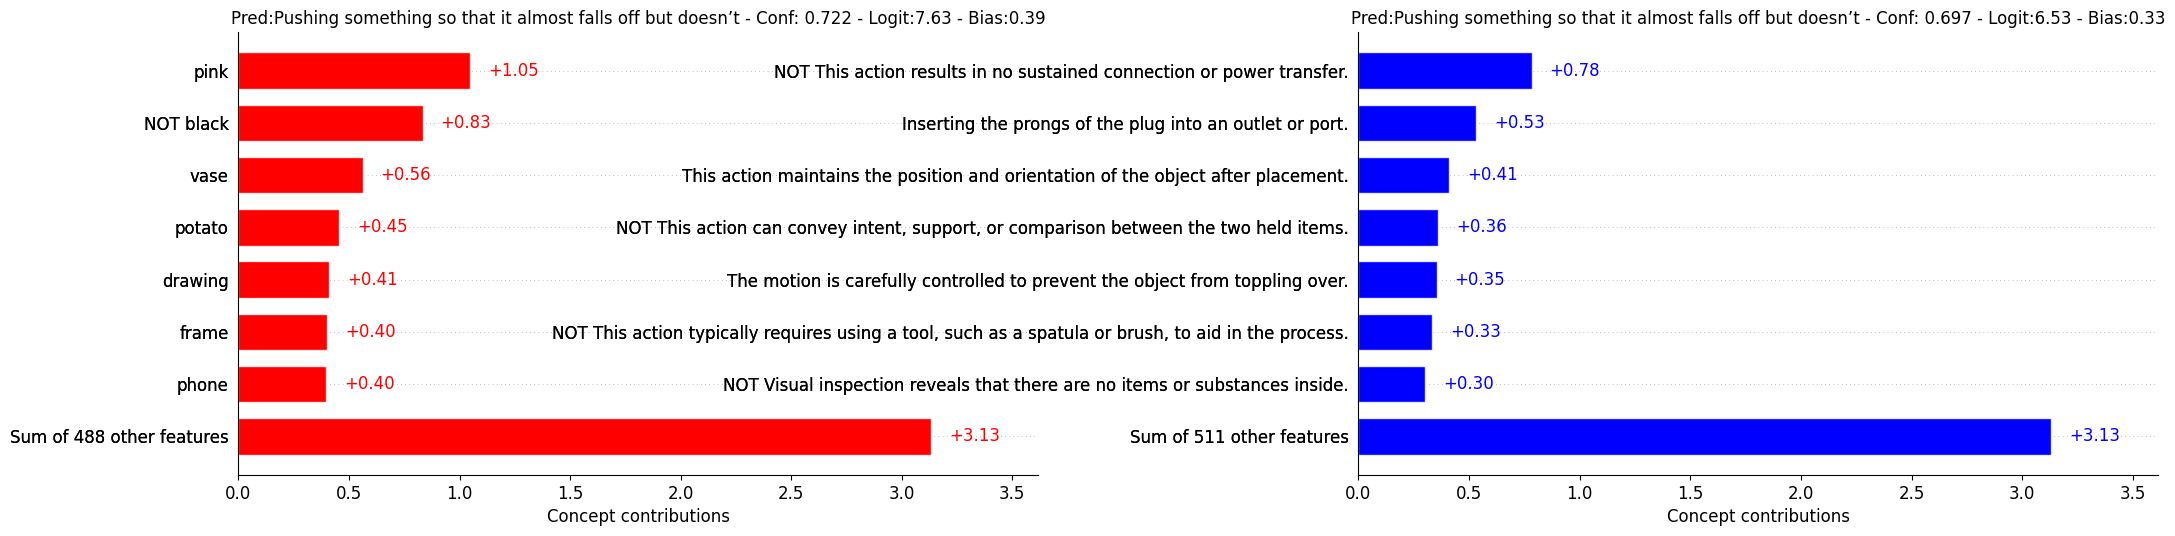

Image:26 Gt:Turning something upside down, 1st Pred:Turning something upside down, 8.591, 2nd Pred:Pretending to turn something upside down, 6.029                                                  Image:26 Gt:Turning something upside down, 1st Pred:Turning something upside down, 8.215, 2nd Pred:Pretending to turn something upside down, 4.398


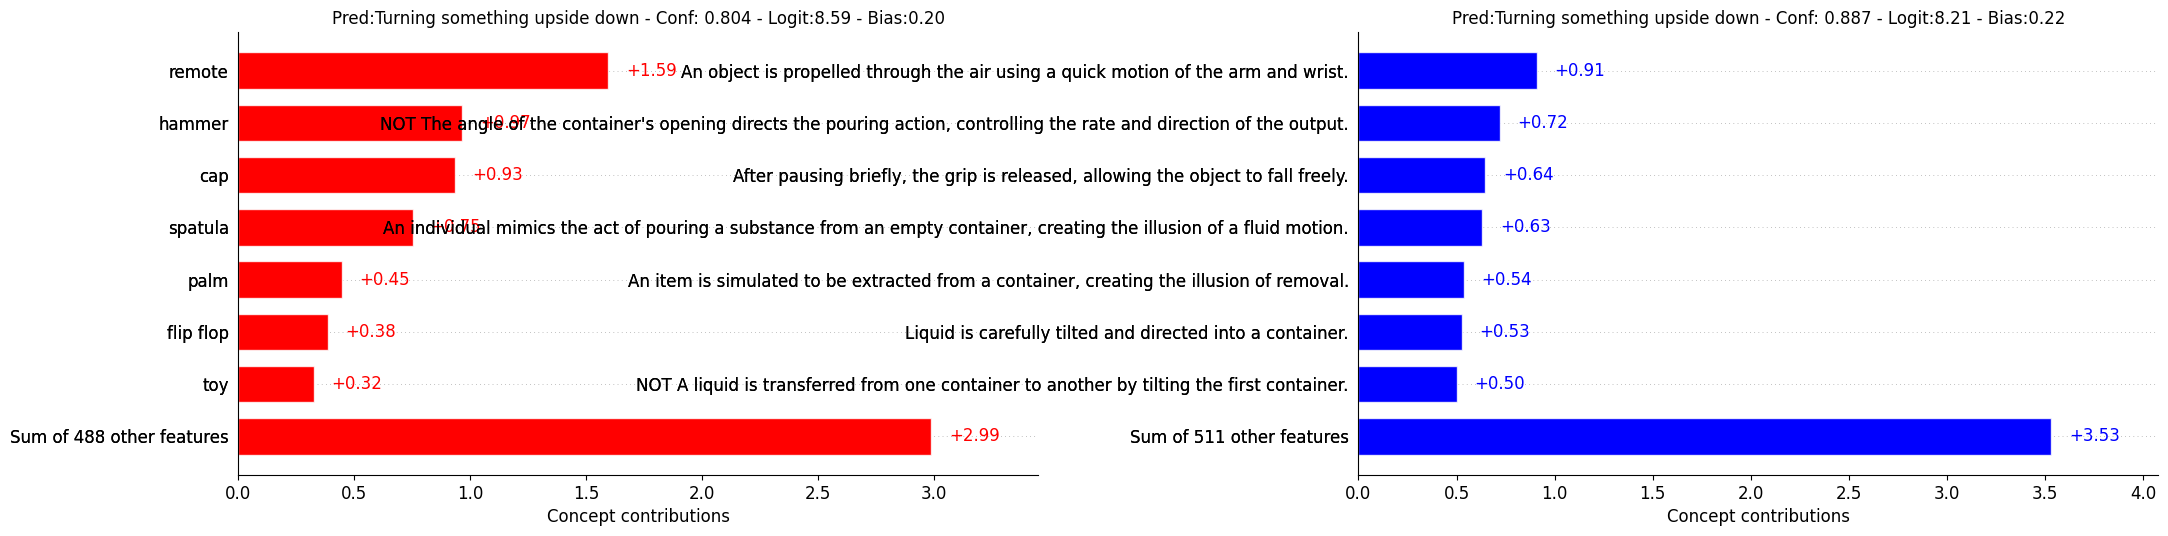

Image:27 Gt:Pushing something so that it falls off the table, 1st Pred:Pushing something so that it falls off the table, 9.940, 2nd Pred:Pushing something off of something, 6.248                                                  Image:27 Gt:Pushing something so that it falls off the table, 1st Pred:Pushing something so that it falls off the table, 6.587, 2nd Pred:Moving something across a surface until it falls down, 4.434


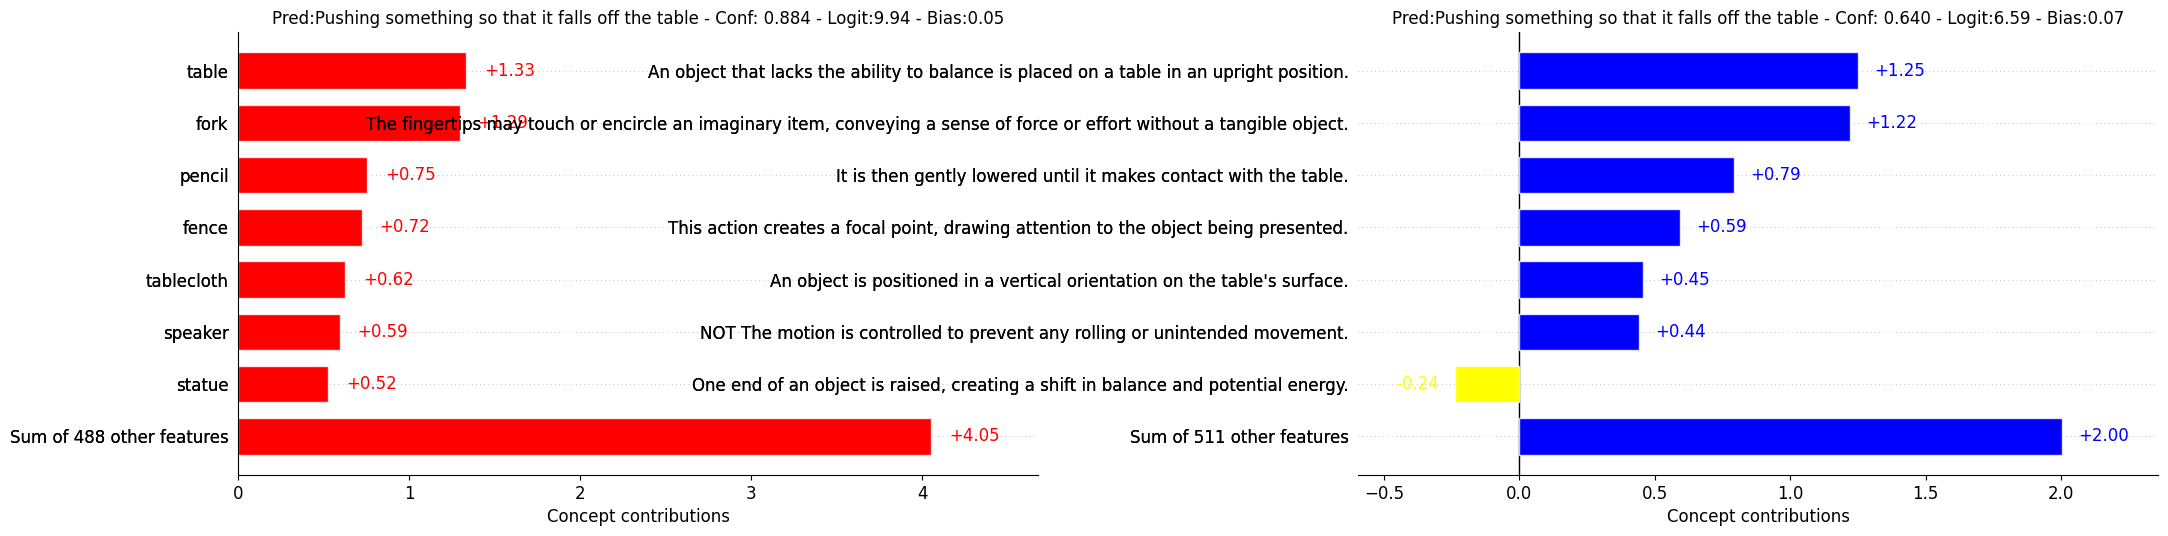

Image:28 Gt:Pretending to pour something out of something but something is empty, 1st Pred:Pretending to pour something out of something but something is empty, 7.046, 2nd Pred:Pouring something into something, 5.557                                                  Image:28 Gt:Pretending to pour something out of something but something is empty, 1st Pred:Pretending to pour something out of something but something is empty, 4.201, 2nd Pred:Pouring something into something, 3.534


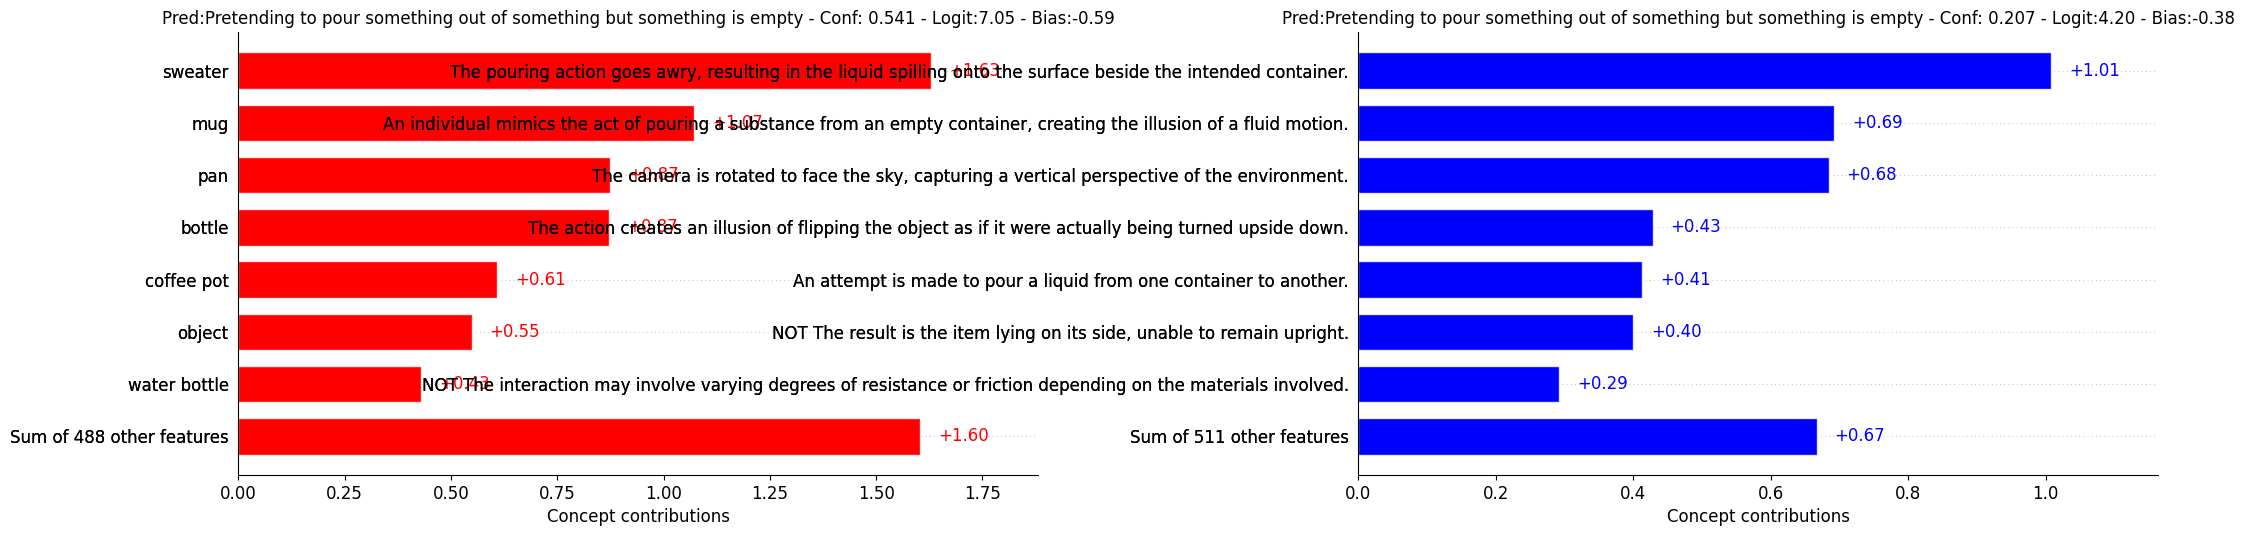

Image:29 Gt:Plugging something into something, 1st Pred:Plugging something into something, 7.539, 2nd Pred:Plugging something into something but pulling it right out as you remove your hand, 4.928                                                  Image:29 Gt:Plugging something into something, 1st Pred:Plugging something into something, 8.469, 2nd Pred:Attaching something to something, 6.279


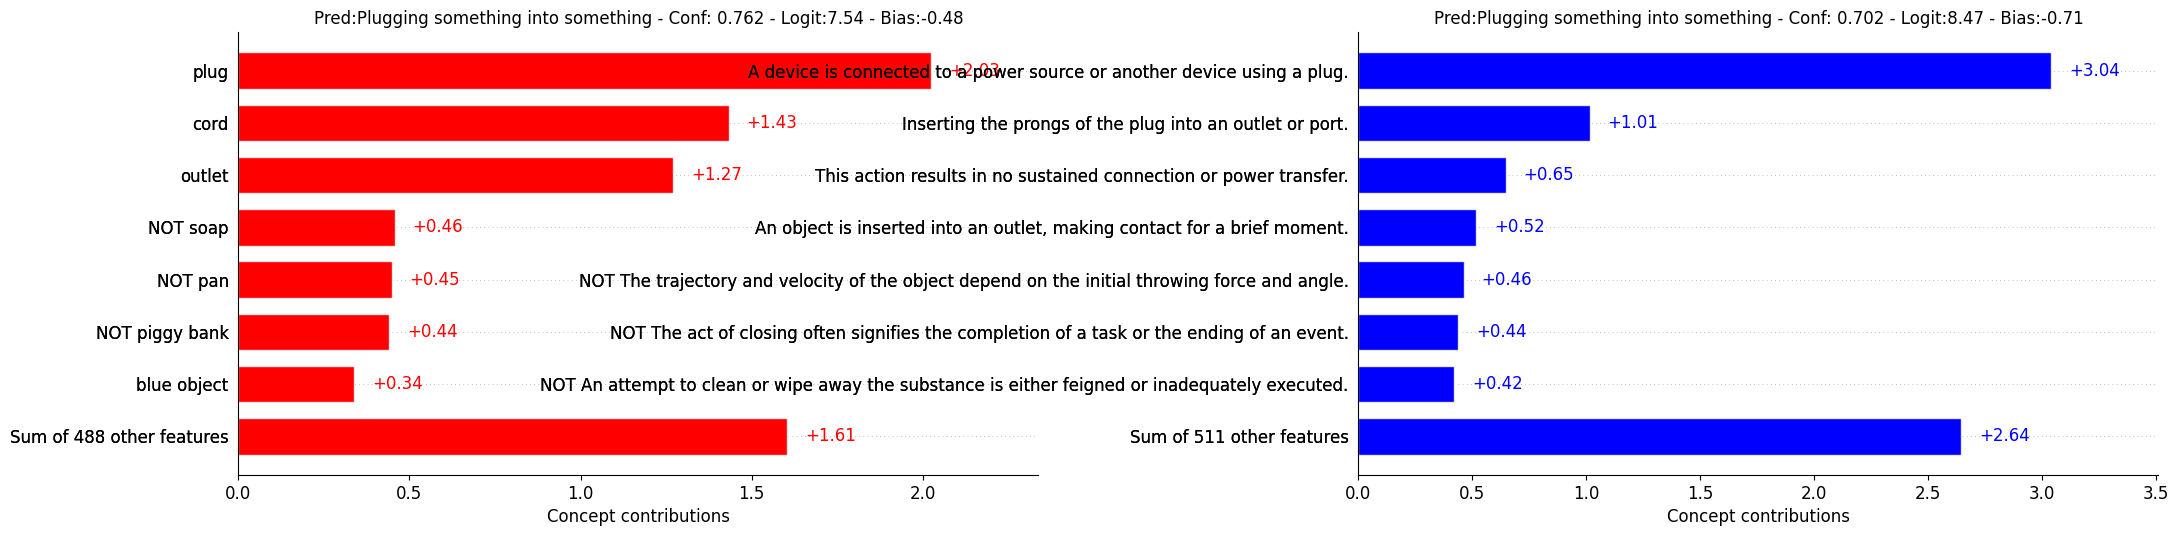

In [30]:
from torchvision.transforms import ToPILImage
from IPython.display import display, HTML, Video
# to_display = random.sample([i for i in range(len(val_pil_data))], k=20)
to_display = [i for i in range(1500)]
import matplotlib.pyplot as plt
to_pil_image = ToPILImage()

with torch.no_grad():
    for i in to_display:
        image,label ,path= val_pil_data[i]
        x, _ = val_data_t[i]
        x = x.unsqueeze(0).to(device)
        s_outputs, s_concept_act = s_model(x)
        t_outputs,t_concept_act = t_model(x)
        # s_correct = s_outputs.argmax()==label
        # t_correct = t_outputs.argmax()==label
        # if (s_correct or t_correct):
            # continue
        display(Video(path, embed=True, width=800, height=600))
        image = to_pil_image(image)
        fig, axs = plt.subplots(1, 2, figsize=(5, 5))
        title_anno={'spatial':None,'temporal':None}
        for j, context in enumerate(['spatial', 'temporal']):
            model = s_model if context=='spatial' else t_model
            concepts = s_concepts if context=='spatial' else t_concepts
            outputs, concept_act = (s_outputs, s_concept_act) if context=='spatial' else (t_outputs, t_concept_act)
            
            top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
            conf = torch.nn.functional.softmax(outputs[0], dim=0)
            title_anno[context]="Image:{} Gt:{}, 1st Pred:{}, {:.3f}, 2nd Pred:{}, {:.3f}".format(i, classes[int(label)], classes[top_classes[0]], top_logit_vals[0],
                                                                        classes[top_classes[1]], top_logit_vals[1])
            
            for k in range(1):  
                contributions = concept_act[0]*model.final.weight[top_classes[k], :]
                feature_names = [("NOT " if concept_act[0][i] < 0 else "") + concepts[i] for i in range(len(concepts))]
                values = contributions.cpu().numpy()
                max_display = min(int(sum(abs(values)>0.005))+1, 8)
                title = "Pred:{} - Conf: {:.3f} - Logit:{:.2f} - Bias:{:.2f}".format(classes[top_classes[k]],
                                conf[top_classes[k]], top_logit_vals[k], model.final.bias[top_classes[k]])
                plt.sca(axs[j])
                plots.bar(values, feature_names, max_display=max_display, show=False,title=title, fontsize=12, pos_color=(1, 0, 0) if context == 'spatial' else (0, 0, 1))
                # plots.bar(values, feature_names, max_display=max_display, title=title, fontsize=16,pos_color=(1,0,0) if context=='spatial' else (0,0,1))
        # plt.tight_layout(pad=40.0
        print(title_anno['spatial'],title_anno['temporal'],sep=' '*50)
        plt.subplots_adjust(left=0.1, right=2.5, top=0.85, bottom=0.1, wspace=0.4)
        plt.show()


In [22]:
model

CBM_model(
  (proj_layer): Linear(in_features=768, out_features=1436, bias=False)
  (final): Linear(in_features=1436, out_features=400, bias=True)
)

In [16]:
model.final.weight.shape

torch.Size([400, 1436])

In [16]:
import numpy as np
from tqdm import tqdm
distribution = np.zeros(768, dtype=int)
for i in tqdm(range(3000)):
    image,label ,path= val_pil_data[i]
    x, _ = val_data_t[i]
    x = x.unsqueeze(0).to(device)
    backbone_feat,concept_activation,outputs = s_model.get_feature(x)
    # outputs, _ = s_model(x)
    top_logit_vals, top_classes = torch.topk(outputs[0], dim=0, k=2)
    contributions = concept_activation[0]*s_model.final.weight[top_classes[0], :]
    high_spatial_concept = torch.topk(contributions, dim=0, k=2)[1][0]
    
    # top_logit_vals, top_classes = torch.topk(concept_activation[0], dim=0, k=5)
    contributions = backbone_feat[0]*s_model.proj_layer.weight[high_spatial_concept, :]
    _,top_dim = torch.topk(contributions, dim=0, k=5)
    dims = top_dim.cpu().numpy()
    distribution += np.bincount(dims, minlength=768)  # 분포 카운트 누적
print(distribution)


100%|██████████| 3000/3000 [19:26<00:00,  2.57it/s]

[ 52  12   6  58   2  18   4  35  53   9  17   3  13  10  10  16  22  33
  45   5  24  23  18   6  25  17  41   3  20   6   0 212   9   7  13  30
   6  11  15  33  11  13  10  37  13  18  14   4  16  21  41  23  47  19
  29  13  32  22   5  23  53  47   7   6   6   5   2  38 100   2  71   4
  16  17   3  10  28   8   8  10  14   4 132   6  13   4   5  10   6  40
  18  10  15  21   2  64   1  17   4  21  11   3  24   8  14  83  25   7
  14  30  20   5  20  33   8  11   9  15  47  17   5   7  15   8  30  12
   4  11   8  37  13  20  14  23  12  33  19  33  77  16  16  11  38  14
  18   6  10   3  36   8  10   9   7   8  37  36   4  10  10  65   7 439
  29   6  12   7  15   2  15  14  26  10  47   5  17  13  11  21   6  22
  50   8  34  22  12  18  41  16   9  18  36   4   9  35   2  10   6   9
   7   8  11  10   1   5  20   7   6  11  82  16  13  33   9  13  26   6
   9   9   8  19   9  17  45   2  49  19  17   5  22  17  52  14  14  33
  25   1   7  10  10  22  16  25  40  26  28  31   

Mean: 19.53125
Median: 13.0
Max: 439
Min: 0
Standard Deviation: 28.764064720947097
Variance: 827.3714192708334
Top 10 most frequent values: [161 307 359  31 697  82 704  68 732 585]
Counts for top 10 values: [439 392 252 212 196 132 110 100 100  86]
Bottom 10 least frequent values: [526  30 539 336 515 600 235 500 440 261]
Counts for bottom 10 values: [0 0 0 0 0 0 1 1 1 1]


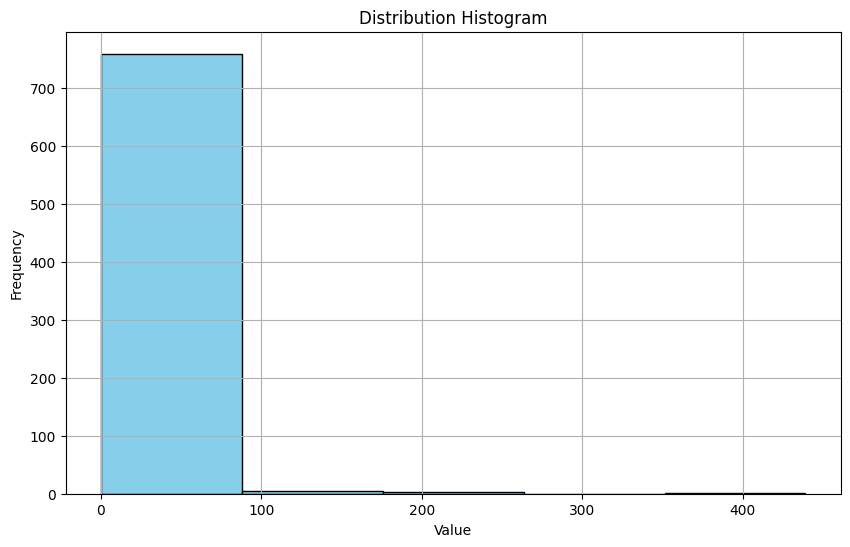

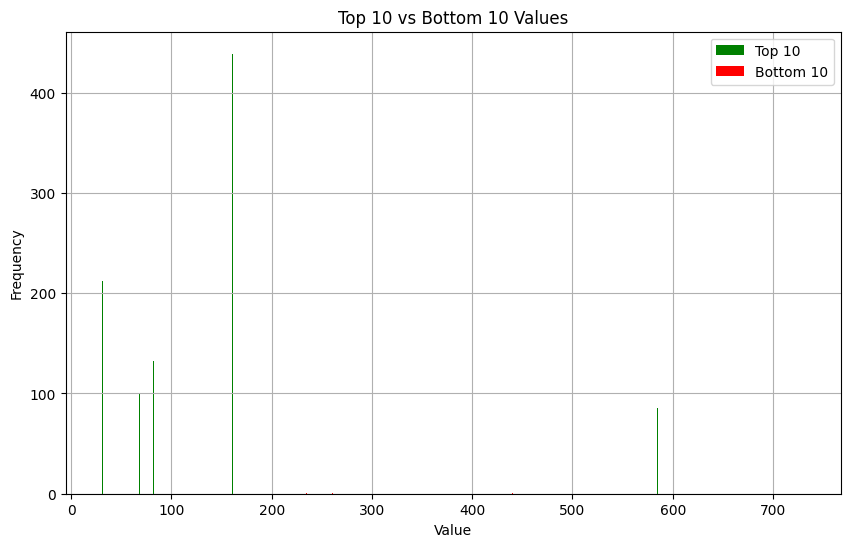

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 예시: distribution 배열 (0부터 767까지의 카운트가 저장된 배열)
# distribution = np.random.randint(0, 100, size=768)  # 예시 데이터

# 분석 지표 계산
mean_value = np.mean(distribution)  # 평균값
median_value = np.median(distribution)  # 중앙값
max_value = np.max(distribution)  # 최댓값
min_value = np.min(distribution)  # 최솟값
std_dev = np.std(distribution)  # 표준편차
variance = np.var(distribution)  # 분산

# 상위 10개 가장 자주 등장한 숫자 찾기
top_10_values = np.argsort(distribution)[-10:][::-1]
top_10_counts = distribution[top_10_values]

# 하위 10개 가장 적게 등장한 숫자 찾기
bottom_10_values = np.argsort(distribution)[:10]
bottom_10_counts = distribution[bottom_10_values]

# 분석 결과 출력
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Max: {max_value}")
print(f"Min: {min_value}")
print(f"Standard Deviation: {std_dev}")
print(f"Variance: {variance}")
print(f"Top 10 most frequent values: {top_10_values}")
print(f"Counts for top 10 values: {top_10_counts}")
print(f"Bottom 10 least frequent values: {bottom_10_values}")
print(f"Counts for bottom 10 values: {bottom_10_counts}")

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
plt.hist(distribution, bins=5, color='skyblue', edgecolor='black')
plt.title("Distribution Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 상위 10개와 하위 10개의 값을 시각화
plt.figure(figsize=(10, 6))

# 상위 10개
plt.bar(top_10_values, top_10_counts, color='green', label="Top 10")
# 하위 10개
plt.bar(bottom_10_values, bottom_10_counts, color='red', label="Bottom 10")

plt.title("Top 10 vs Bottom 10 Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# 400 이상의 값이 몇 개 있는지 확인
above_400 = np.sum(distribution[400:])
print(f"400 이상의 값이 등장한 횟수: {above_400}")

400 이상의 값이 등장한 횟수: 6398


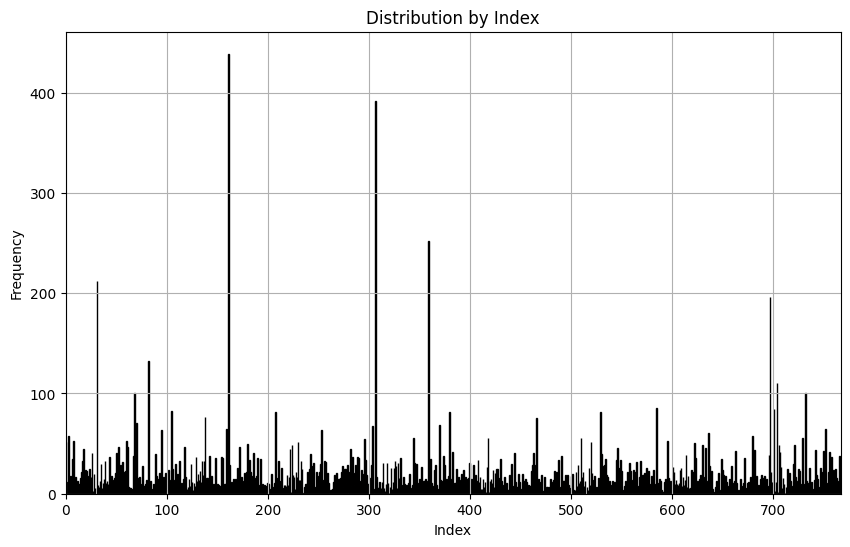

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 예시 데이터: distribution 배열
distribution = np.array([52,12,6,58,2,18,4,35,53,9,17,3,13,10,10,16,22,33
,45,5,24,23,18,6,25,17,41,3,20,6,0,212,9,7,13,30
,6,11,15,33,11,13,10,37,13,18,14,4,16,21,41,23,47,19
,29,13,32,22,5,23,53,47,7,6,6,5,2,38,100,2,71,4
,16,17,3,10,28,8,8,10,14,4,132,6,13,4,5,10,6,40
,18,10,15,21,2,64,1,17,4,21,11,3,24,8,14,83,25,7
,14,30,20,5,20,33,8,11,9,15,47,17,5,7,15,8,30,12
,4,11,8,37,13,20,14,23,12,33,19,33,77,16,16,11,38,14
,18,6,10,3,36,8,10,9,7,8,37,36,4,10,10,65,7,439
,29,6,12,7,15,2,15,14,26,10,47,5,17,13,11,21,6,22
,50,8,34,22,12,18,41,16,9,18,36,4,9,35,2,10,6,9
,7,8,11,10,1,5,20,7,6,11,82,16,13,33,9,13,26,6
,9,9,8,19,9,17,45,2,49,19,17,5,22,17,52,14,14,33
,25,1,7,10,10,22,16,25,40,26,28,31,5,7,22,18,3,22
,30,64,14,13,33,32,20,21,11,1,4,4,5,12,19,6,21,6
,15,15,16,22,28,7,25,25,11,29,1,22,45,8,37,21,9,29
,16,37,36,2,13,24,13,20,55,34,19,10,10,7,16,29,68,5
,1,392,17,6,6,12,6,12,31,6,3,10,31,11,1,7,26,5
,12,26,33,28,6,31,16,36,9,5,17,10,0,9,5,11,20,2
,6,9,56,31,21,30,11,6,15,5,27,3,13,13,15,13,7,252
,22,35,11,3,8,24,29,9,2,5,69,14,13,8,38,29,9,15
,5,18,82,12,15,42,4,11,11,25,10,17,11,14,20,3,24,11
,17,15,6,16,31,8,15,14,29,15,19,13,34,12,17,5,5,15
,7,12,2,27,56,2,13,15,11,24,7,21,25,25,11,16,35,13
,9,7,17,7,11,4,4,19,1,30,7,8,41,12,7,7,20,12
,5,2,20,13,1,15,12,7,9,8,8,23,29,41,3,29,76,2
,15,12,8,19,3,3,17,2,7,7,2,7,15,12,4,14,23,12
,22,14,34,7,6,38,13,13,13,19,9,19,9,6,1,18,20,4
,4,22,8,29,11,13,56,17,22,8,13,0,7,4,26,9,52,21
,14,18,5,7,0,16,8,82,40,28,12,29,35,19,17,4,13,0
,9,13,2,12,4,34,46,26,25,34,23,3,4,8,13,11,22,16
,31,23,14,1,24,22,4,32,8,2,17,33,17,19,19,21,8,26
,6,23,3,10,18,6,24,3,10,86,10,11,15,13,4,2,2,12
,15,3,53,16,2,13,0,27,22,10,14,10,9,11,24,26,8,17
,9,14,39,7,18,6,6,24,21,22,51,36,8,13,8,15,19,8
,49,3,17,46,13,7,61,28,6,23,5,1,2,7,13,4,21,4
,1,35,24,19,10,18,12,8,3,15,9,28,5,11,13,43,11,3
,4,2,15,8,4,11,36,5,6,11,12,9,17,6,58,4,44,1
,18,2,9,2,15,19,3,16,18,9,15,8,39,196,22,12,12,85
,3,12,110,2,49,42,27,6,16,10,1,7,25,4,21,13,4,8
,30,49,17,13,9,25,23,8,10,56,6,10,100,13,9,11,26,1
,12,5,3,14,44,19,15,7,4,26,8,22,43,18,65,11,8,22
,42,12,37,10,24,21,25,16,13,3,38,20])

# 인덱스 생성 (0부터 767까지)
indices = np.arange(len(distribution))

# 막대 그래프 (bar plot) 그리기
plt.figure(figsize=(10, 6))
plt.bar(indices, distribution, color='skyblue', edgecolor='black')
plt.title("Distribution by Index")
plt.xlabel("Index")  # 각 index가 가로축에 표시됨
plt.ylabel("Frequency")  # distribution 값이 세로축에 표시됨
plt.grid(True)

# 가로축 범위를 0부터 767까지 설정
plt.xlim(0, 767)
plt.show()

In [35]:
sorted_indices = np.argsort(distribution)

# 상위 N개와 하위 N개의 활성화된 차원 인덱스 및 값 찾기
N = 300  # 예: 상위 10개, 하위 10개의 차원을 출력
bottom_N_indices = sorted_indices[:N]  # 하위 N개
top_N_indices = sorted_indices[-N:][::-1]  # 상위 N개 (큰 값부터 출력)

# 해당 차원의 활성화 횟수
bottom_N_values = distribution[bottom_N_indices]
top_N_values = distribution[top_N_indices]

# 결과 출력
print(f"Top {N} most activated dimensions: {top_N_indices}")
print(f"Activation counts for most activated dimensions: {top_N_values}\n")

print(f"Top {N} least activated dimensions: {bottom_N_indices}")
print(f"Activation counts for least activated dimensions: {bottom_N_values}")

Top 300 most activated dimensions: [161 307 359  31 697  82 704  68 732 585 701 105 529 208 380 138 466  70
 370 304 159 752 253  95 636 680   3 510 729 418 344 296 596  60   8 520
   0 230 622 180 630 721 706 224 172 118  61  52 546 633 222 282  18 742
 682 750 663 707 383 756 186 463  26 444  50  89 530 242 614 696 374 142
 766  67 491 129  43 758 284 289 154 148 190 155 623 290 331 672 649 430
 193 361 534   7 182 408 297 549 545 488 137  17 211  39 569 326 233 135
 113 256 565 257  56 329 345 400 558 245 314 318 252 124 441 720 109 347
  35 279 507 287 465  54 303 462 366 162 404 533 375 274 244 327 659  76
 531 637 601 352 708 417 609 747 736 170 547 518 214 325 322 243 575 426
 762 387  24 277 234 714 276 548 241 427 106 725 582 760 619 293 650 365
 562  20 423 608 394 102 550 461 484 559 726 577  51 639 133  59  21 505
 698  57 239 486 755 512 749 360 183  16 228 556 179 248 251 621 602 563
 281 273 346 573  49 285 761  93 521  99 268 425 259 716 177 646 620  28
 204 340 295 502